
## 프로젝트: 인물 모드 문제점 찾기
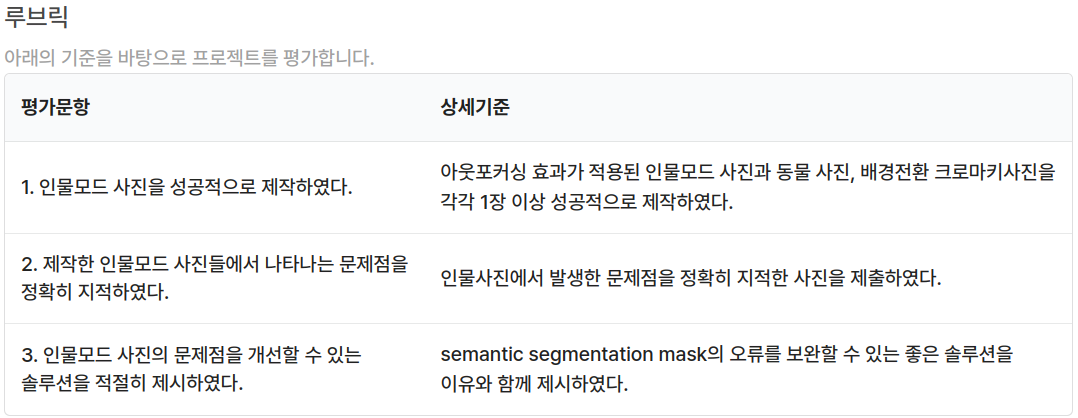   

모든 이미지는 저작권이 없는 unsplash 이미지를 사용했습니다. 

In [1]:
# 라이브러리 불러오기 
from importlib.metadata import version
import os
import urllib
import cv2
import numpy as np
import pixellib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## 1. 인물모드 직접 해 보기


### 1) 첫 번째 이미지 : 배경이 단순한 인물 사진 

(4684, 3747, 3)


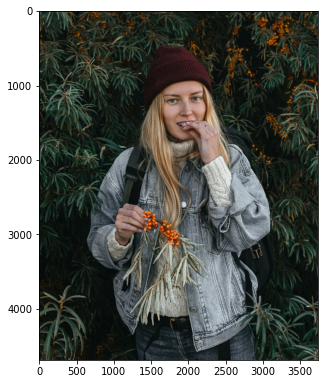

In [2]:
# 이미지 불러오기 
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/woman2.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 모델 불러오기 
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1baa6b1b80>)

In [4]:
# semantic segmentation을 수행하는 클래스 인스턴스를 만들기 
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

In [5]:
# segmentAsPascalvoc() 함수 호출
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [6]:
# pascalvoc 데이터의 라벨 종류 
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

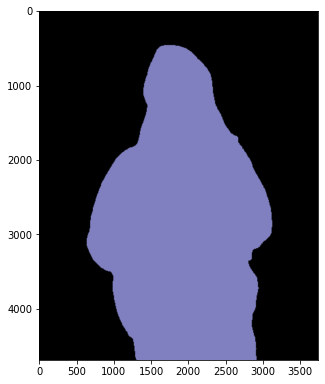

In [7]:
# 이미지 분할한 output 출력 
plt.figure(figsize=(5,10))
plt.imshow(output)
plt.show()

In [8]:
# output의 배열값 출력 
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# ouput의 라벨 출력 
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] 

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람의 컬러맵 출력 
colormap[15] 

array([192, 128, 128])

In [12]:
# 사람의 컬러맵 적용
seg_color = (128,128,192) 

(4684, 3747)


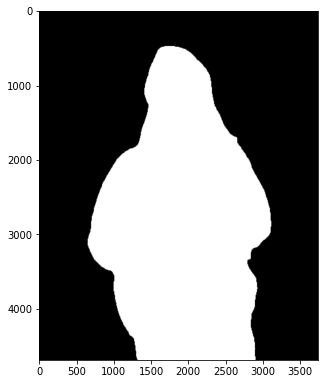

In [13]:
# 사람이 있는 위치를 흰 색으로 출력 
seg_map = np.all(output==seg_color, axis=-1) 
mask_girl = seg_map.copy()
print(seg_map.shape) 

plt.figure(figsize=(5,10))
plt.imshow(seg_map, cmap='gray')
plt.show()

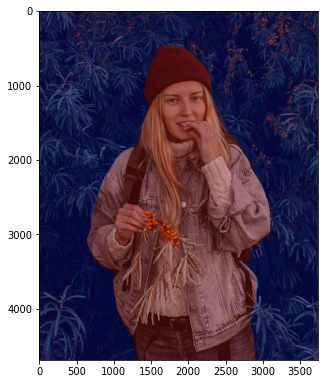

In [14]:
# 마스크 만들어 섞기 
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

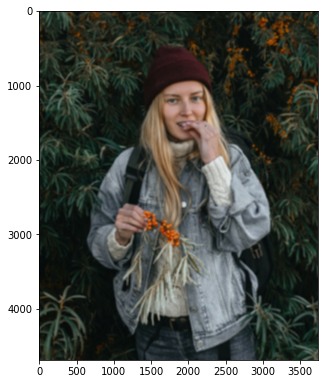

In [15]:
# blurring
img_orig_blur = cv2.blur(img_orig, (30,30))
 
plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

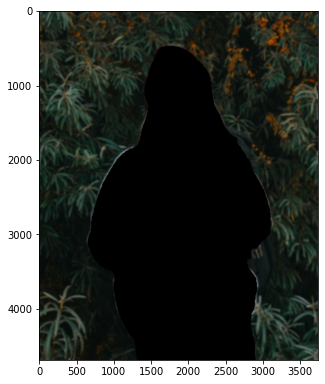

In [16]:
# 베경만 남기기 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

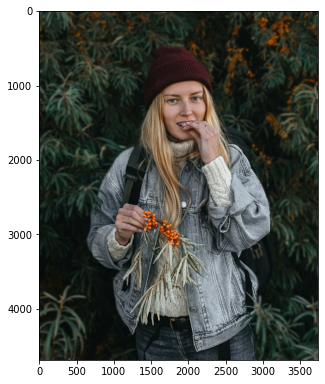

In [17]:
# 이미지 합치기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_girl = img_concat.copy()

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

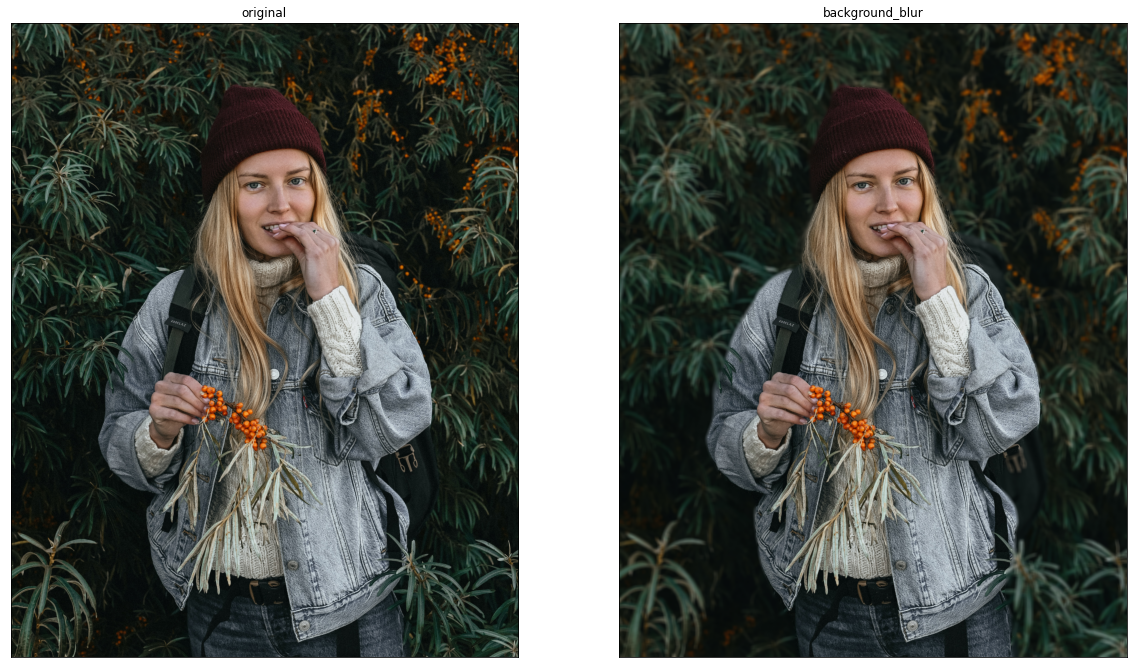

In [18]:
# 원본과 비교 
fig = plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) 
plt.title('background_blur')
plt.xticks([])
plt.yticks([])
plt.show()

배경의 원근이 일정해서 그런지, 상의의 색상 자체가 희미해서 그런지..생각보다 윤곽선이 자연스럽다.  

Ref.   
https://inhovation97.tistory.com/56 subplot으로 이미지 여러개 출력하기    

#### 이미지 배경 바꾸기 : np.where

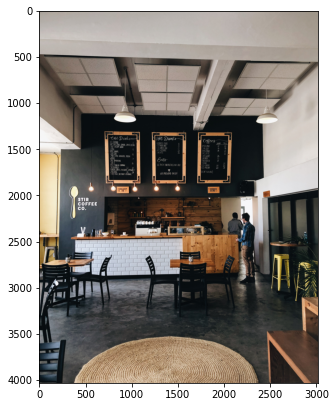

In [19]:
# 배경 불러오기 
cafe_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cafe1.jpg'  
img_cafe = cv2.imread(cafe_path) 

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_cafe, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
print(img_cafe.shape)
print(img_orig.shape)

(4032, 3024, 3)
(4684, 3747, 3)


In [21]:
# 인물만 남기고 나머지는 0(검은색) 처리
girl_only_img_concat = np.where(img_mask_color==255, img_orig, 0)

# 이미지 resize
img_cafe_resize = cv2.resize(img_cafe, (3747, 4684)) # (y, x)순으로 

img_cafe_resize.shape

(4684, 3747, 3)

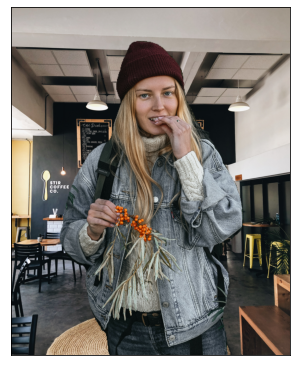

In [22]:
# 이미지 합성하기 
con = np.where(img_mask_color==255, girl_only_img_concat, img_cafe_resize)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(con, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

새로운 배경이 잘 합성되었다.   
인물의 크기를 조절하면 더 자연스러울 것 같은데, 원본 이미지와 배경 이미지의 크기가 같아야해서 이 방법으로는 인물 크기를 줄일 수 없을 것 같다. 

#### 이미지 배경 바꾸기 : copyTo

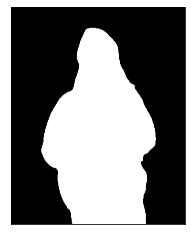

In [23]:
# 마스크 저장하기 
plt.imshow(seg_map, cmap='gray')
plt.xticks([])
plt.yticks([])

# 보여지는 이미지를 그대로 저장(현재 디렉토리에)
plt.savefig('girl_mask.jpg') 

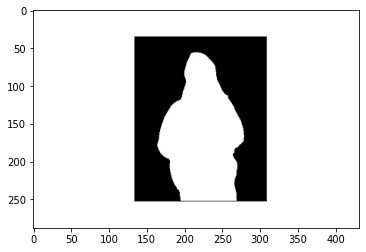

In [24]:
# 마스크 불러오기 
mask_path = os.getenv('HOME')+'/aiffel/0Going Deeper/girl_mask.jpg'  
mask_girl = cv2.imread(mask_path) 

plt.imshow(cv2.cvtColor(mask_girl, cv2.COLOR_BGR2RGB))
plt.show()

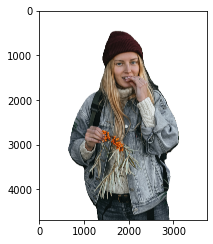

In [25]:
# 배경 지우기 
white_back_girl = np.where(img_mask_color==255, img_orig, 255)

plt.figure(figsize=(3,5))
plt.imshow(cv2.cvtColor(white_back_girl, cv2.COLOR_BGR2RGB))
plt.show()

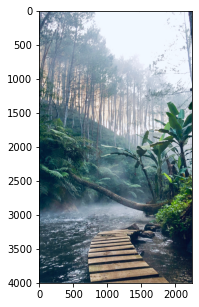

In [26]:
# 배경 불러오기 
back_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jungle.jpg'  
jungle = cv2.imread(back_path) 

plt.figure(figsize=(3,5))
plt.imshow(cv2.cvtColor(jungle, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
white_back_girl.shape

(4684, 3747, 3)

In [28]:
mask_girl.shape

(288, 432, 3)

In [29]:
jungle.shape

(4001, 2251, 3)

In [30]:
# 이미지 사이즈 변경 
white_back_girl_resize = cv2.resize(white_back_girl, (432, 288)) # (y, x)순으로 
jungle_resize = cv2.resize(jungle, (432, 288)) 

In [31]:
# 이미지 합성 
# cv2.copyTo(white_back_girl_resize, mask_girl, jungle_resize)

# cv2.imshow('jungle', jungle_resize)

인물 사이즈를 줄인 합성 이미지를 얻고 싶어서, 크기가 다른 두 이미지를 합성하는 방법을 찾아봤다.    
아래 블로그를 참고해서 copyTo를 이용해 배경을 바꿔보았는데, 이미지 사이즈를 줄여도 계속 copyTo에서 커널이 꺼지는 문제가 생겼다.  
  
또한 블로그에서는 배경보다 대상이 작아서 배경을 crop해도 괜찮았지만, 내 이미지는 배경보다 대상이 크기때문에 배경을 crop할 수 없었다.   
seg_map을 savefig로 저장해 마스크로 사용했는데, seg_map에 비해 불러온 마스크의 크기가 확연하게 작아졌다.  
어떻게하면 사이즈 그대로 저장할 수 있을까?

Ref.   
[크기가 다른 이미지로 배경 바꾸기](https://yeko90.tistory.com/entry/opencv-%EB%91%90-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%95%A9%EC%B9%98%EB%8A%94-%EB%B0%A9%EB%B2%95-%ED%81%AC%EA%B8%B0-%EB%8B%A4%EB%A5%B8-%EC%9D%B4%EB%AF%B8%EC%A7%80) 

### 2) 두 번째 이미지 : 동물 사진 

(4032, 3024, 3)


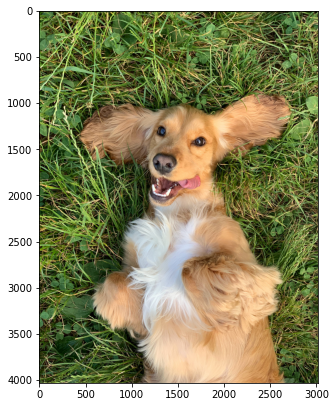

In [118]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog4.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [119]:
segvalues, output = model.segmentAsPascalvoc(img_path)

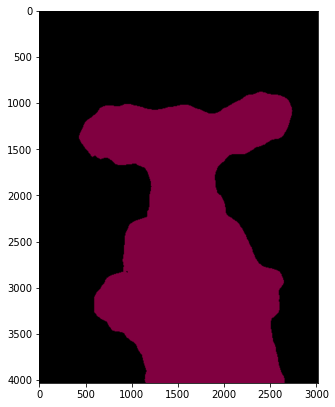

In [120]:
plt.figure(figsize=(5,10))
plt.imshow(output)
plt.show()

In [121]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [122]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [123]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] 

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [124]:
# 개의 컬러맵 출력 
colormap[12]

array([ 64,   0, 128])

In [125]:
# 개의 컬러맵 적용
seg_color = (128,0,64)

(4032, 3024)


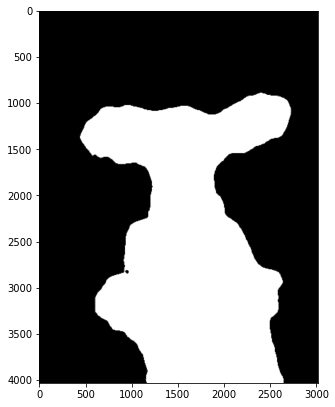

In [126]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 

plt.figure(figsize=(5,10))
plt.imshow(seg_map, cmap='gray')
plt.show()

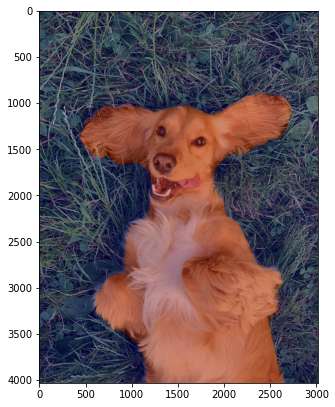

In [127]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

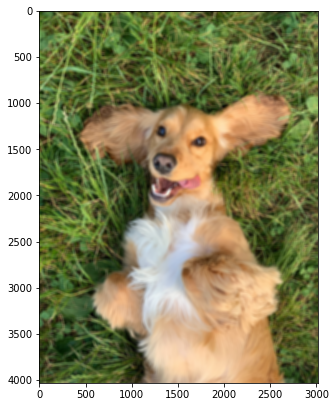

In [128]:
img_orig_blur = cv2.blur(img_orig, (35,35))
  
plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

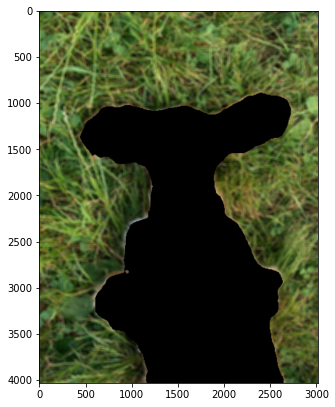

In [129]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

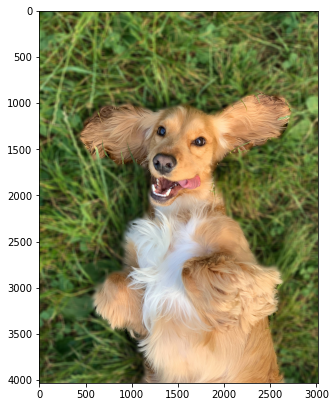

In [130]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_dog = img_concat.copy()

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

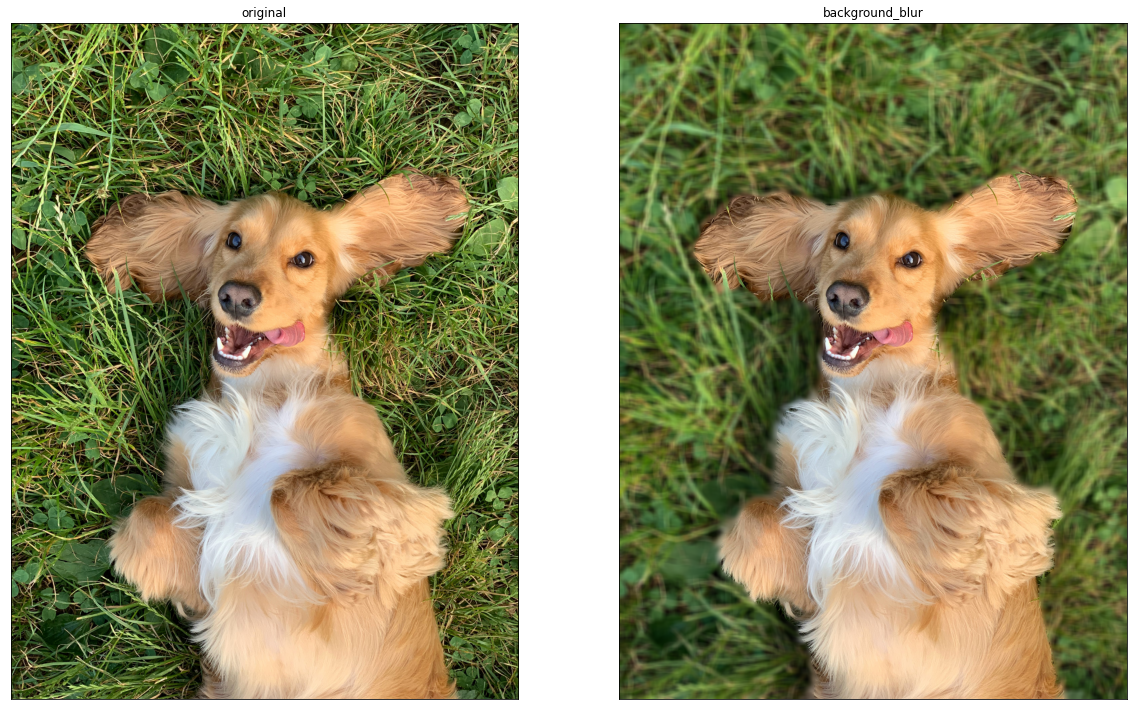

In [132]:
fig = plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) 
plt.title('background_blur')
plt.xticks([])
plt.yticks([])
plt.show()

귀 부분에 선명한 잔디가 섞여있고 오른쪽 어깨와 발 부분이 모호하지만, 생각보다 잘나왔다. 

#### 이미지 배경 바꾸기

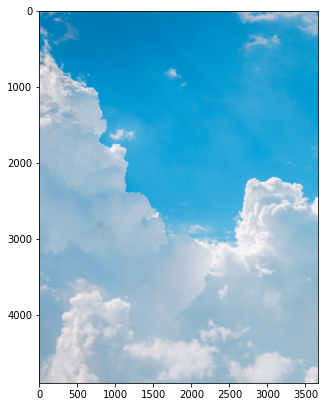

In [46]:
sky_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky.jpg'  
img_sky = cv2.imread(sky_path) 

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(img_sky, cv2.COLOR_BGR2RGB))
plt.show()

In [47]:
print(img_sky.shape)
print(img_orig.shape)

(4893, 3670, 3)
(4032, 3024, 3)


In [48]:
# 대상만 남기고 나머지는 0(검은색) 처리
dog_only_img_concat = np.where(img_mask_color==255, img_orig, 0)

# 이미지 resize
img_sky_resize = cv2.resize(img_sky, (3024, 4032)) 

img_sky_resize.shape

(4032, 3024, 3)

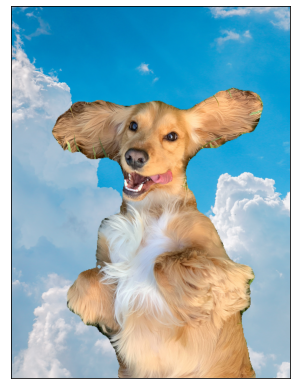

In [49]:
# 이미지 합성하기 
con = np.where(img_mask_color==255, dog_only_img_concat, img_sky_resize)

plt.figure(figsize=(5,10))
plt.imshow(cv2.cvtColor(con, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

아무래도 강아지 윤곽선은 털과 잔디 때문에 깔끔하지 않아서, 인물 합성보다 훨씬 부자연스럽다.     
                                                                                         
                                                                                                       
#### (2)에서 계속.. 